
The notebook covers Following Topics

- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- PCA

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from scipy.stats import kendalltau
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import warnings
matplotlib.style.use("ggplot")
#pd.options.mode.changed_assignment = None
#warnings.filterwarnings("ignore")
%matplotlib inline

Reading In Dataset
training file and property for 2016. Will be merging the two to create an efficient document to test errors on

In [3]:
train = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

In [4]:
train.columns

Index(['parcelid', 'logerror', 'transactiondate'], dtype='object')

In [2]:
properties = pd.read_csv("properties_2016.csv", low_memory = True)

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

Shape of Dataset

In [6]:
print ('shape of training set: ', train.shape)
print ('shape of properties dataframe: ', properties.shape)

shape of training set:  (90275, 3)
shape of properties dataframe:  (2985217, 58)


Merge 'Train' and 'Properties' for EDA

In [6]:
merged = pd.merge(train,properties,on="parcelid",how="left")

In [8]:
merged.head(3)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


In [8]:
merged.head(4).transpose()

,0,1,2,3
parcelid,11016594,14366692,12098116,12643413
logerror,0.0276,-0.1684,-0.004,0.0218
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-02 00:00:00
airconditioningtypeid,NaN,NaN,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN
bathroomcnt,NaN,NaN,NaN,NaN
bedroomcnt,NaN,NaN,NaN,NaN
buildingclasstypeid,NaN,NaN,NaN,NaN
buildingqualitytypeid,NaN,NaN,NaN,NaN


Visualising Datatypes

In [22]:
pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"Variable Type", 0:"Count"})

,Variable Type,Count
0,object,58
1,float64,1
2,datetime64[ns],1


In [7]:
dataType = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"Variable Type", 0:"Count"})

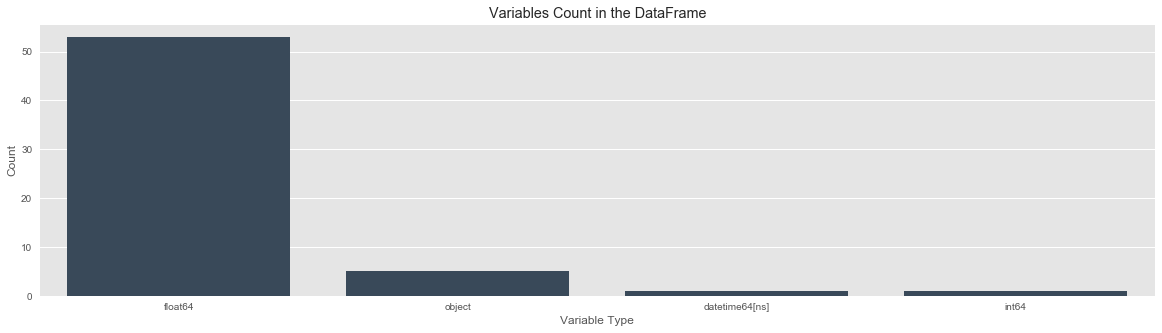

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.barplot(data=dataType, x = "Variable Type", y = "Count", ax = ax, color="#34495e")
ax.set(xlabel = "Variable Type", ylabel = "Count", title = "Variables Count in the DataFrame")

Missing Value Analysis

In [9]:
### Calculate number of missing values per column
missingValueColumns = merged.columns[merged.isnull().any()].tolist()

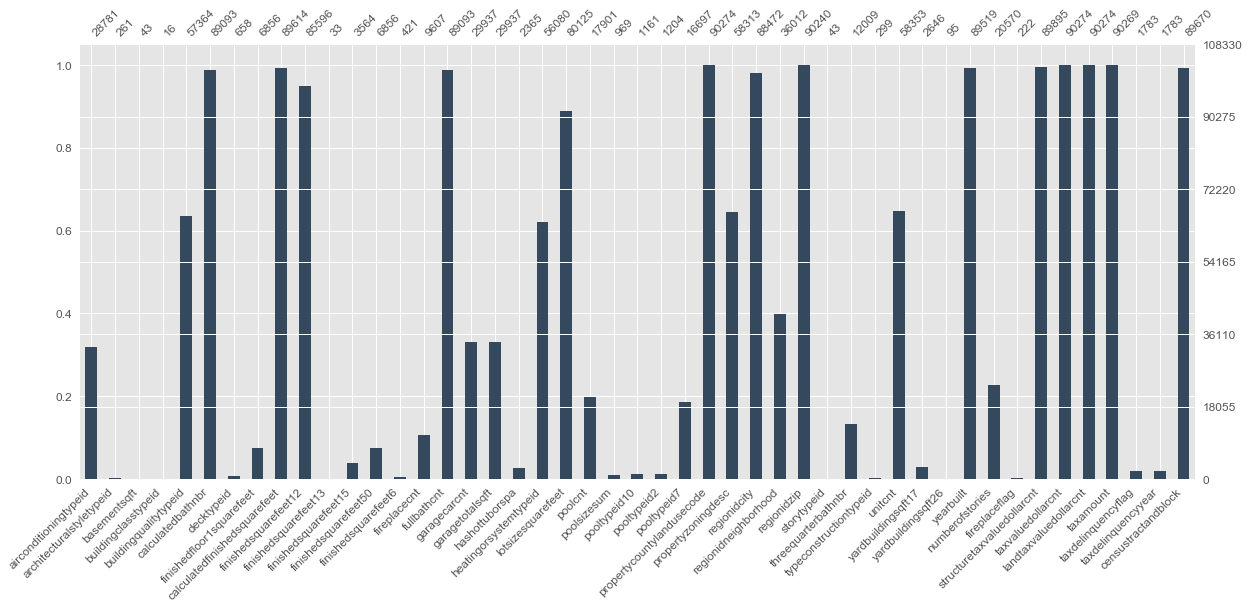

In [10]:
### Right hand axis shows value figure, minor axis by 18,055
### Count showing missing values by column
msno.bar(merged[missingValueColumns], figsize=(20,8),color="#34495e",fontsize=12,labels=True,)

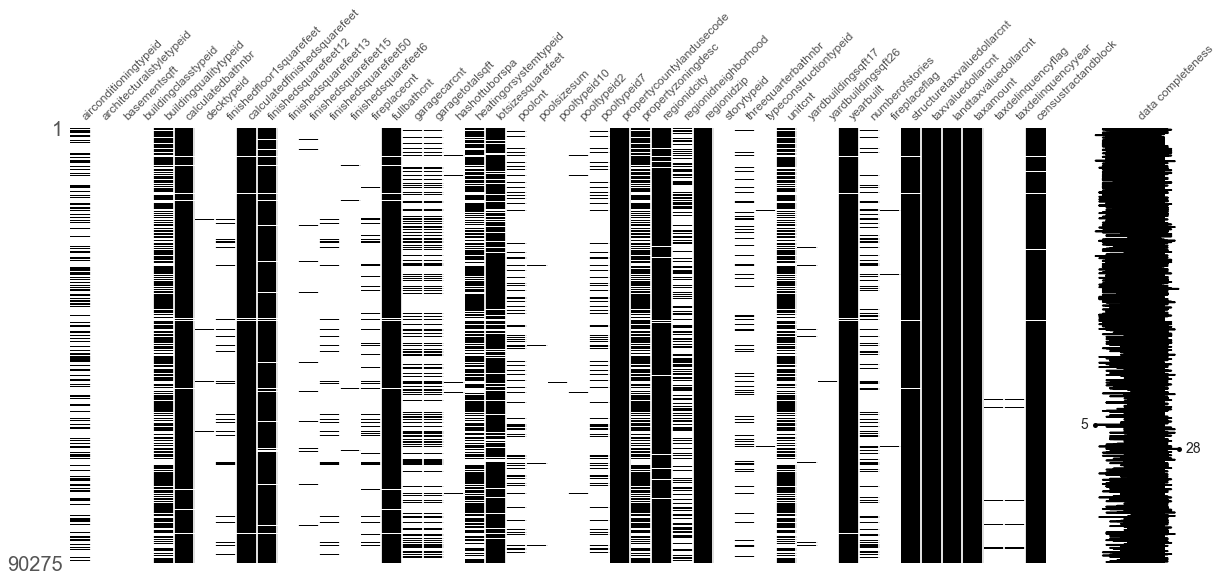

In [11]:
### Missing data demonstrated by column density
msno.matrix(merged[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0,0, 0),fontsize=12,sparkline=True,labels=True)

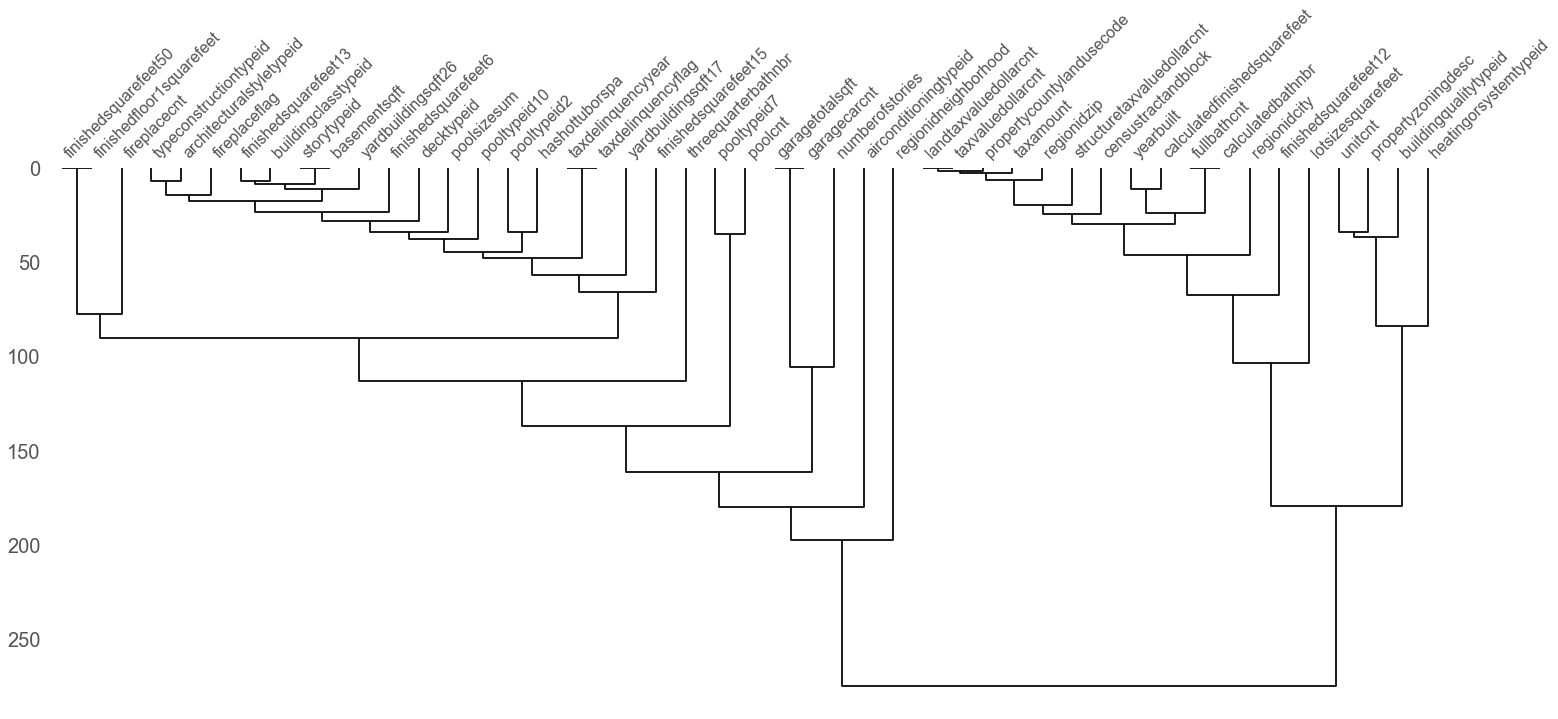

In [12]:
### Shows taxonomic relationships:
msno.dendrogram(merged[missingValueColumns])

### Top Features Selection

In [14]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
#warnings.filterwarnings("ignore")

In [18]:
### Have set 'NaN' values to 0.

filteredMerged = merged.fillna(value=0)

In [26]:
### Values with datatype 'object' are given a numeric value

for f in filteredMerged.columns:
    if filteredMerged[f].dtype == 'object':
        processed = preprocessing.LabelEncoder()
        processed.fit(list(filteredMerged[f].values))
        filteredMerged[f] = processed.transform(list(filteredMerged[f].values))

In [30]:
### Train to predict logerror values

trainY = filteredMerged.logerror.values
trainX = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1)

In [31]:
xgb_params = {'eta': 0.05,'max_depth': 8,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear',
    'eval_metric': 'rmse','silent': 1}

In [35]:
dtrain = xgb.DMatrix(trainX, trainY, feature_names=trainX.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

In [37]:
featureImportance = model.get_fscore()
featureImportance

{'airconditioningtypeid': 161,
 'architecturalstyletypeid': 5,
 'basementsqft': 22,
 'bathroomcnt': 459,
 'bedroomcnt': 330,
 'buildingclasstypeid': 35,
 'buildingqualitytypeid': 125,
 'calculatedbathnbr': 65,
 'calculatedfinishedsquarefeet': 658,
 'censustractandblock': 84,
 'decktypeid': 7,
 'finishedfloor1squarefeet': 62,
 'finishedsquarefeet12': 308,
 'finishedsquarefeet13': 5,
 'finishedsquarefeet15': 136,
 'finishedsquarefeet50': 22,
 'finishedsquarefeet6': 61,
 'fips': 16,
 'fireplacecnt': 19,
 'fullbathcnt': 28,
 'garagecarcnt': 22,
 'garagetotalsqft': 54,
 'hashottuborspa': 18,
 'heatingorsystemtypeid': 70,
 'landtaxvaluedollarcnt': 365,
 'latitude': 614,
 'longitude': 505,
 'lotsizesquarefeet': 568,
 'numberofstories': 13,
 'poolcnt': 34,
 'poolsizesum': 4,
 'pooltypeid10': 4,
 'pooltypeid2': 3,
 'pooltypeid7': 10,
 'propertycountylandusecode': 102,
 'propertylandusetypeid': 88,
 'propertyzoningdesc': 219,
 'rawcensustractandblock': 367,
 'regionidcity': 132,
 'regionidcounty

In [38]:
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)

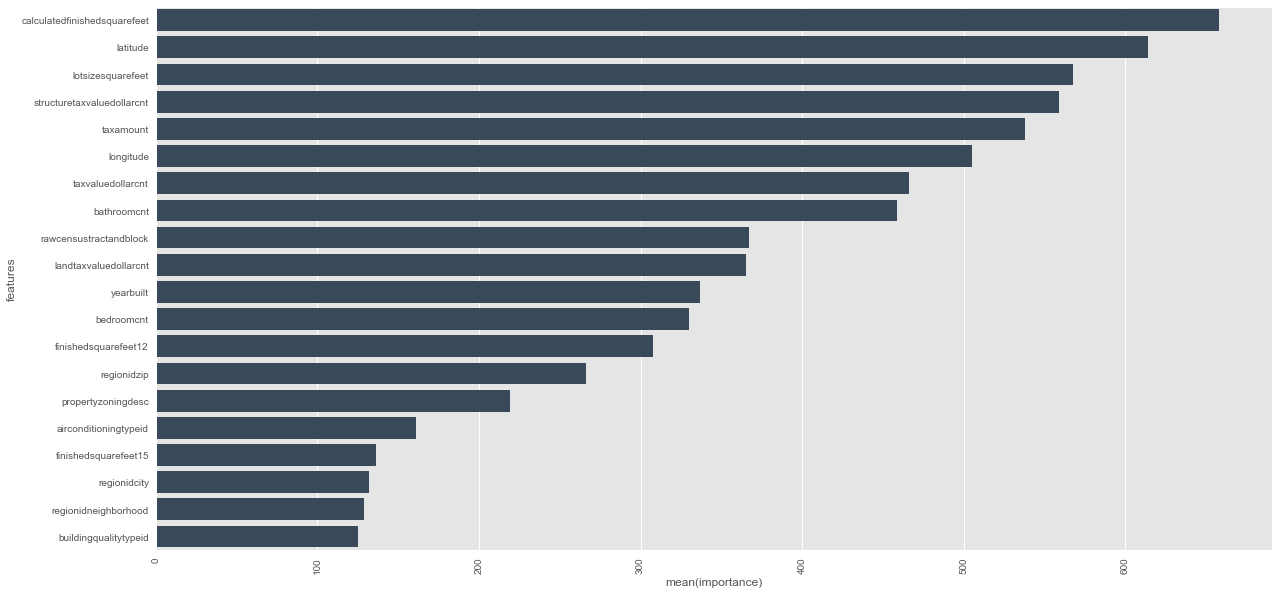

In [40]:
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")

### Correlation Analysis with Heatmap

In [95]:
features["features"].tolist()[:15]

['calculatedfinishedsquarefeet',
 'latitude',
 'lotsizesquarefeet',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'longitude',
 'taxvaluedollarcnt',
 'bathroomcnt',
 'rawcensustractandblock',
 'landtaxvaluedollarcnt',
 'yearbuilt',
 'bedroomcnt',
 'finishedsquarefeet12',
 'regionidzip',
 'propertyzoningdesc']

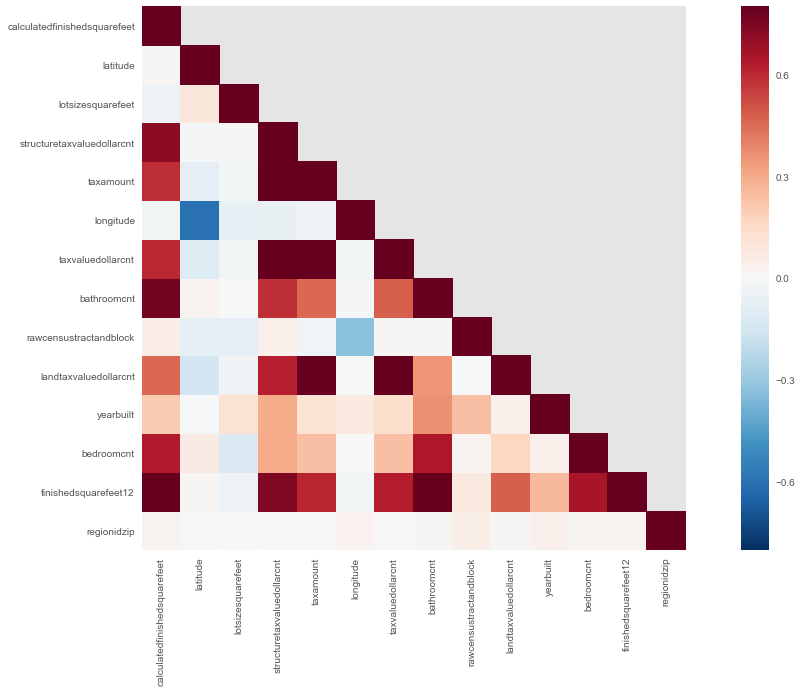

In [96]:
topFeatures = features["features"].tolist()[:15]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

You can detect high-multi-collinearity by inspecting the eigen values of correlation matrix. 
A very low eigen value shows that the data are collinear, and the corresponding eigen vector shows which 
variables are collinear.
accepted
If there is no collinearity in the data, you would expect that none of the eigen values are close to zero:


each eigen vector explains the variation in the data orthogonal to other eigen vectors, and the eigen value shows 
how much variation is in that direction. 
An almost zero eigen value shows a direction with zero variation, hence collinearity

### PCA

In [45]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
### Train to predict logerror values

trainY = filteredMerged.logerror.values
trainX = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1)

In [46]:
X, y = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1), filteredMerged.logerror.values

In [47]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state=0)

In [50]:
print (Xtrain.shape)
print (ytrain.shape)
print (Xtest.shape)
print (ytest.shape)

(81247, 57)
(81247,)
(9028, 57)
(9028,)


In [51]:
sc = StandardScaler()

In [97]:
Xtrain_std = sc.fit_transform(Xtrain)
Xtest_std = sc.transform(Xtest)

Constructing the covariance matrix
- using linalg.eig function to obtain eigenpairs

In [54]:
covMatrix = np.cov(Xtrain_std.T)

In [55]:
eigenValues, eigenVectors = np.linalg.eig(covMatrix)

In [56]:
print("\nEigenvalues \n%s" % eigenValues)


Eigenvalues 
[  9.63796823e+00   6.69518688e+00   4.00308979e+00   2.50796689e+00
   2.37362768e+00   2.10430843e+00   1.96564652e+00   1.86132171e+00
   1.79214152e+00   1.73124069e+00   1.48230212e+00   1.21273259e+00
   1.15656212e+00   1.07392389e+00   1.03949565e+00   1.01563849e+00
   9.95667618e-01   9.87927279e-01   9.72001199e-01   9.56527959e-01
   9.15626125e-01   8.83767522e-01   8.46385758e-01   8.01396190e-01
   6.89414603e-01   6.68066697e-01   5.87164374e-01   5.23703752e-01
   4.93352768e-01   4.64884503e-01   4.37435287e-01   4.03200708e-01
   3.93884246e-01   3.43456599e-01   3.05510254e-01   2.96354536e-01
   2.29784300e-01   2.17376823e-01   1.73084338e-01   1.52931888e-01
   1.45816872e-01   1.30980517e-01   8.57954779e-02   7.42882370e-02
   7.02788248e-02   5.65104726e-02   1.84062986e-02   2.15717433e-02
   4.05444895e-03   8.93058326e-04   3.47840632e-05  -2.40274337e-15
   1.59645950e-15  -7.31445994e-16  -4.28005766e-16   9.16392902e-17
   0.00000000e+00]


In [68]:
len(eigenValues)

57

Caculate cumulative sum of explained variances, then plot matplotlib "step" function

In [57]:
Total = sum(eigenValues)
varianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)]
cumulativeVarianceExplained = np.cumsum(varianceExplained)


In [66]:
len(varianceExplained)

57

In [67]:
len(cumulativeVarianceExplained)

57

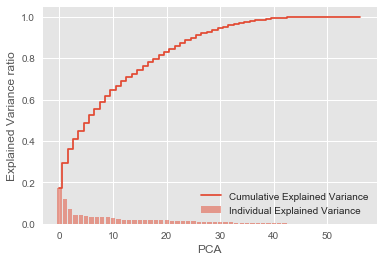

In [75]:
plt.bar(range(57),varianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(57), cumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.figure(figsize=(10,10))
plt.show()
plt.close()

In [86]:
BULKvarianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)][:30]
BULKcumulativeVarianceExplained = np.cumsum(BULKvarianceExplained)

In [87]:
print(len(BULKvarianceExplained))
print(len(BULKcumulativeVarianceExplained))

30
30


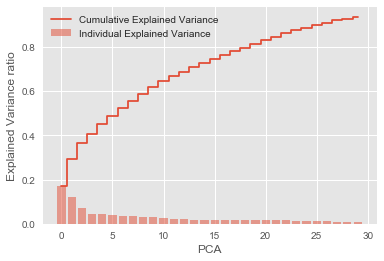

In [85]:
plt.bar(range(30),BULKvarianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(30), BULKcumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()
plt.close()

### Top 15 Features provide bulk of the information

In [93]:
TOPvarianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)][:15]
TOPcumulativeVarianceExplained = np.cumsum(TOPvarianceExplained)

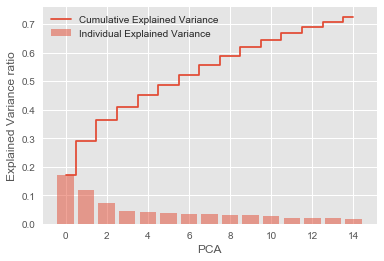

In [94]:
plt.bar(range(15),TOPvarianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(15), TOPcumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()
plt.close()